In [ ]:
pip install imblearn

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
Data Info:
 None

Missing Values:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left    

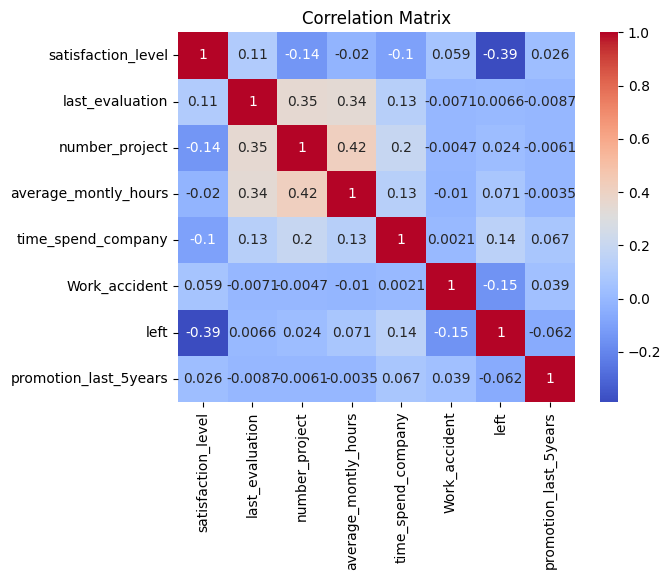

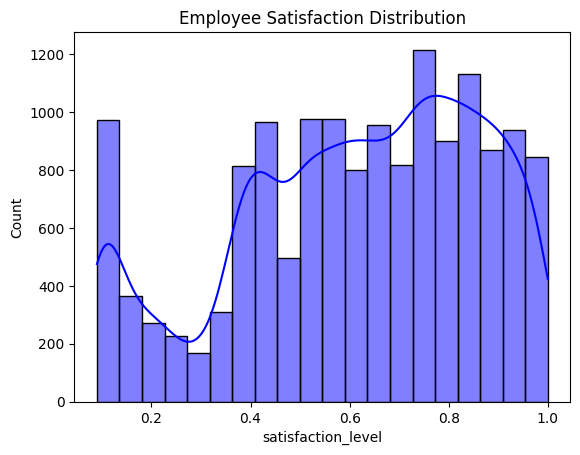

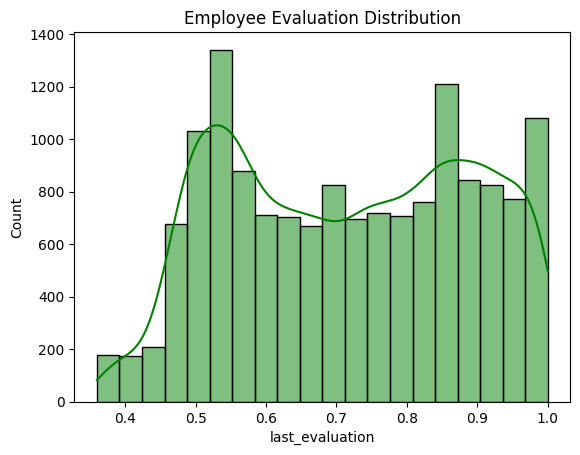

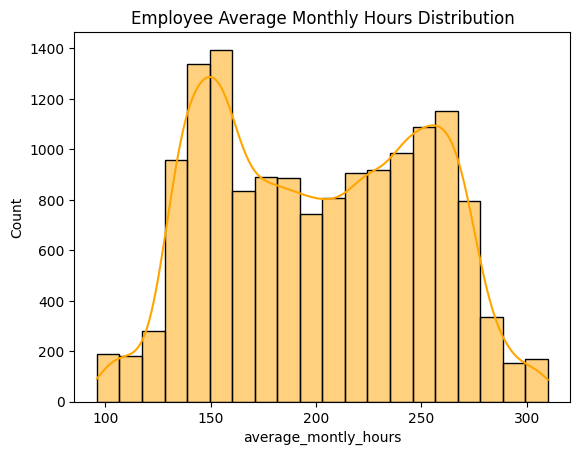

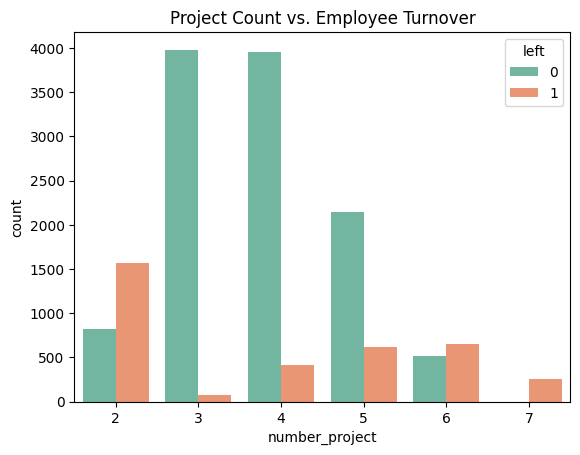

In [6]:
# Load dataset
data_path = "hr_comma_sep.csv"  
data = pd.read_csv(data_path)

# 1. Data Quality Checks
print("Data Info:\n", data.info())
print("\nMissing Values:\n", data.isnull().sum())

# 2. Exploratory Data Analysis (EDA)
## 2.1 Correlation Matrix and Heatmap
# Exclude non-numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Calculate the correlation matrix
# Correlation matrix is a table showing correlation coefficients between variables. 
# Each cell in the table shows the correlation between two variables. The value is in the range of -1 to 1.
# If two variables have high correlation, it means thery are strongly related.
# Values close to 1 mean that the two variables have a strong positive correlation.
# Values close to -1 mean that the two variables have a strong negative correlation.
# Values close to 0 mean that there is no correlation between the variables.
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## 2.2 Distribution Plots
sns.histplot(data['satisfaction_level'], kde=True, bins=20, color='blue')
plt.title("Employee Satisfaction Distribution")
plt.show()

sns.histplot(data['last_evaluation'], kde=True, bins=20, color='green')
plt.title("Employee Evaluation Distribution")
plt.show()

sns.histplot(data['average_montly_hours'], kde=True, bins=20, color='orange')
plt.title("Employee Average Monthly Hours Distribution")
plt.show()

## 2.3 Bar Plot: Project Count vs. Turnover
sns.countplot(x='number_project', hue='left', data=data, palette='Set2')
plt.title("Project Count vs. Employee Turnover")
plt.show()



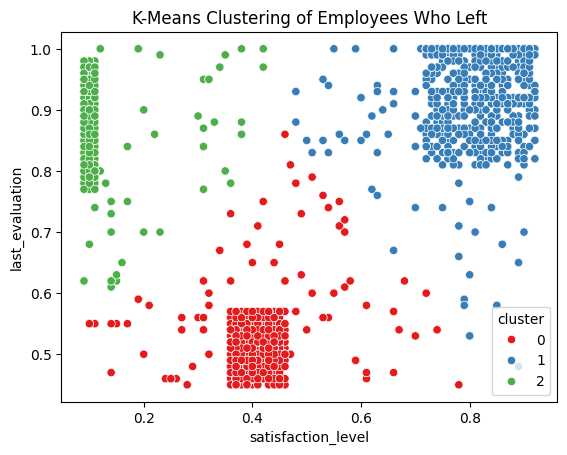


Logistic Regression
Accuracy: 0.7952

Random Forest
Accuracy: 0.9838

Gradient Boosting
Accuracy: 0.9630

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      2286
           1       0.51      0.74      0.60       714

    accuracy                           0.77      3000
   macro avg       0.71      0.76      0.72      3000
weighted avg       0.81      0.77      0.78      3000


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Gradient Boosting Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2286
    

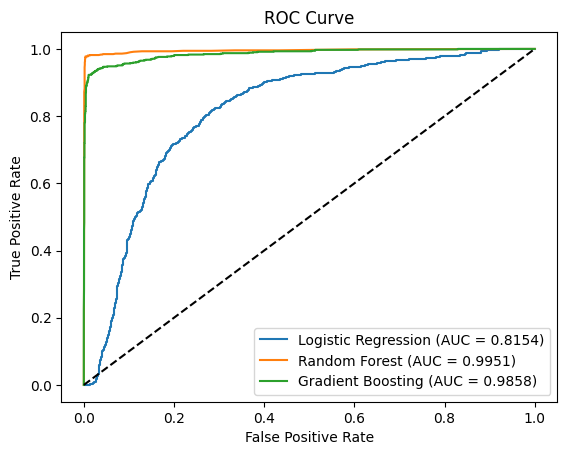

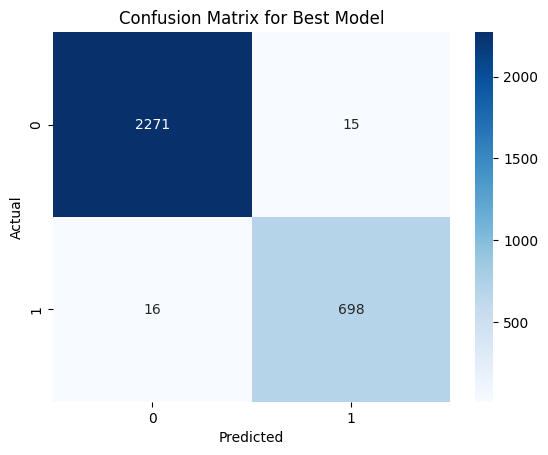

Retention Category
Safe Zone           1240
High-Risk Zone       647
Low-Risk Zone        128
Medium-Risk Zone      58
Name: count, dtype: int64

Retention Strategies:
Safe Zone: Regular engagement and acknowledgment.
Low-Risk Zone: Recognize and reward efforts, offer support.
Medium-Risk Zone: Provide growth opportunities and reduce workload.
High-Risk Zone: Immediate intervention, conduct personalized discussions.


In [10]:
# 3. Clustering of Employees Who Left
left_employees = data[data['left'] == 1][['satisfaction_level', 'last_evaluation']]

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(left_employees)
left_employees['cluster'] = kmeans.labels_

sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=left_employees, palette='Set1')
plt.title("K-Means Clustering of Employees Who Left")
plt.show()

# 4. Handle Class Imbalance with SMOTE
## 4.1 Data Preprocessing
data = pd.get_dummies(data, columns=['sales', 'salary'], drop_first=True)
X = data.drop('left', axis=1)
y = data['left']

## 4.2 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

## 4.3 SMOTE Oversampling
smote = SMOTE(random_state=123, sampling_strategy= 1.0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 5. Model Training with 5-Fold Cross-Validation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=123),
    "Gradient Boosting": GradientBoostingClassifier(random_state=123)
}

for model_name, model in models.items():
    print(f"\n{model_name}")
    scores = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring='accuracy') # scoring='f1'
    print(f"Accuracy: {np.mean(scores):.4f}")
    
# Train Models and Evaluate Performance
best_model = None
best_auc = 0

for model_name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Calculate ROC/AUC
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})")

    if auc_score > best_auc:
        best_auc = auc_score
        best_model = model

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Confusion Matrix for Best Model
y_best_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_best_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7. Retention Strategies
# Predict Probabilities
probabilities = best_model.predict_proba(X_test)[:, 1]
retention_categories = pd.cut(probabilities, bins=[0, 0.2, 0.6, 0.9, 1], labels=['Safe Zone', 'Low-Risk Zone', 'Medium-Risk Zone', 'High-Risk Zone'])

# Output Retention Strategies
test_results = pd.DataFrame({
    'Probability': probabilities,
    'Retention Category': retention_categories
})
print(test_results['Retention Category'].value_counts())

# Suggest Retention Strategies for Each Zone
print("\nRetention Strategies:")
print("Safe Zone: Regular engagement and acknowledgment.")
print("Low-Risk Zone: Recognize and reward efforts, offer support.")
print("Medium-Risk Zone: Provide growth opportunities and reduce workload.")
print("High-Risk Zone: Immediate intervention, conduct personalized discussions.")
